### 1. Import necessary libraries:

In [388]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from mltools.regression_tools import LinearRegressor
from mltools import regression_tools as RT

import numpy as np

### 2. Load data as a Pandas DataFrame:

In [389]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [390]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

Merging both dataframes into one. Converting hourly irradiation and hourly utilization columns into a single column for each variable. Creating a new columns for time-frange.

In [391]:
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')


# Separando el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformando los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')


# Ajustando la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)


df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraer las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unir los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [392]:
df_final

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion
0,2015,1,1,3,00,0.0,0.0
1,2015,1,2,4,00,0.0,0.0
2,2015,1,3,5,00,0.0,0.0
3,2015,1,4,6,00,0.0,0.0
4,2015,1,5,0,00,0.0,0.0
...,...,...,...,...,...,...,...
17531,2020,12,27,6,21,0.0,0.0
17532,2020,12,28,0,21,0.0,0.0
17533,2020,12,29,1,21,0.0,0.0
17534,2020,12,30,2,21,0.0,0.0


In [393]:
df_final.dtypes

ANNO               int64
MES                int64
DIA                int64
DIASEM             int64
FranjaHoraria     object
Irradiacion      float64
Utilizacion      float64
dtype: object

In [394]:
# Convertir la columna "FranjaHoraria" a tipo int
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)


In [395]:
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

In [396]:
df_final

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion
0,2015,1,1,3,0,0.000,0.000000
2192,2015,1,1,3,3,0.000,0.000000
4384,2015,1,1,3,6,0.000,0.027848
6576,2015,1,1,3,9,414536.220,0.235443
8768,2015,1,1,3,12,1193085.200,0.263291
...,...,...,...,...,...,...,...
8767,2020,12,31,3,9,32165.098,0.011194
10959,2020,12,31,3,12,75464.914,0.024876
13151,2020,12,31,3,15,10270.279,0.001244
15343,2020,12,31,3,18,0.000,0.000000


Creation of lags for the previos time periods, day and year.

In [397]:
df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes


df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

In [398]:
df_final

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
0,2015,1,1,3,0,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2192,2015,1,1,3,3,0.000,0.000000,0.000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
4384,2015,1,1,3,6,0.000,0.027848,0.000,0.000,NaN,NaN,0.000000,0.000000,NaN,NaN
6576,2015,1,1,3,9,414536.220,0.235443,0.000,0.000,NaN,NaN,0.027848,0.000000,NaN,NaN
8768,2015,1,1,3,12,1193085.200,0.263291,414536.220,0.000,NaN,NaN,0.235443,0.027848,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,2020,12,31,3,9,32165.098,0.011194,0.000,0.000,147171.42,353766.8,0.002902,0.000000,0.046020,0.251244
10959,2020,12,31,3,12,75464.914,0.024876,32165.098,0.000,228807.36,1009271.3,0.011194,0.002902,0.073383,0.276534
13151,2020,12,31,3,15,10270.279,0.001244,75464.914,32165.098,236625.10,423595.5,0.024876,0.011194,0.024461,0.050580
15343,2020,12,31,3,18,0.000,0.000000,10270.279,75464.914,0.00,0.0,0.001244,0.024876,0.000000,0.000415


In [399]:
df_final.describe()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
count,17536.000000,17536.000000,17536.000000,17536.000000,17536.00000,1.753600e+04,17536.000000,1.753500e+04,1.753400e+04,1.752800e+04,1.461600e+04,17535.000000,17534.000000,17528.000000,14616.000000
mean,2017.500456,6.521898,15.732664,3.000000,10.50000,4.729477e+05,0.079512,4.729747e+05,4.730017e+05,4.731569e+05,4.726322e+05,0.079517,0.079521,0.079546,0.081055
std,1.708230,3.449085,8.801621,1.999601,6.87406,7.341697e+05,0.117820,7.341820e+05,7.341942e+05,7.342718e+05,7.348932e+05,0.117822,0.117823,0.117836,0.119549
min,2015.000000,1.000000,1.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,8.000000,1.000000,5.25000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000422
50%,2017.500000,7.000000,16.000000,3.000000,10.50000,0.000000e+00,0.010896,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010896,0.010896,0.010896,0.011759
75%,2019.000000,10.000000,23.000000,5.000000,15.75000,7.341657e+05,0.127996,7.341787e+05,7.341917e+05,7.346999e+05,7.311085e+05,0.127996,0.127996,0.128109,0.129854
max,2020.000000,12.000000,31.000000,6.000000,21.00000,3.017838e+06,0.537553,3.017838e+06,3.017838e+06,3.017838e+06,3.017838e+06,0.537553,0.537553,0.537553,0.537553


Drop of Nan

In [400]:
df_final = df_final.dropna()

In [401]:
# Paso 'ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria' a categóricas
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

C:\Users\Ainhoa\AppData\Local\Temp\ipykernel_19400\177449398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['ANNO'] = df_final['ANNO'].astype('category')
C:\Users\Ainhoa\AppData\Local\Temp\ipykernel_19400\177449398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['MES'] = df_final['MES'].astype('category')
C:\Users\Ainhoa\AppData\Local\Temp\ipykernel_19400\177449398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

### 3. Split the data into training and test sets:

In [402]:
# Define input and output matrices
INPUTS = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria', 'Irradiacion',	'Irradiacion_lag1',	'Irradiacion_lag2',	'Irradiacion_lag8',	'Irradiacion_lag365',	'Utilizacion_lag1',	'Utilizacion_lag2',	'Utilizacion_lag8',	'Utilizacion_lag365']
OUTPUT = 'Utilizacion'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS]
y = df_final[OUTPUT]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                test_size=0.2,  #percentage of test data
                                                random_state=999) #seed for replication

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test

X_train.head()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
6323,2020,4,23,3,6,1.296732e+05,0.00,0.00,63635.453,61282.887,0.000000,0.000000,0.099917,0.035109
17259,2020,3,30,0,21,0.000000e+00,0.00,992001.94,0.000,0.000,0.000000,0.062189,0.000000,0.000000
9439,2016,11,2,2,12,1.507416e+06,875906.94,0.00,867919.100,253890.660,0.243882,0.032911,0.232068,0.087342
17473,2020,10,30,4,21,0.000000e+00,0.00,778723.70,0.000,0.000,0.000000,0.051410,0.000000,0.000000
5369,2017,9,12,1,6,7.804512e+03,0.00,0.00,20514.133,22217.970,0.004071,0.000000,0.049299,0.089030


In [403]:
len(X_train)

11692

In [404]:
len(X_test)

2924

In [405]:
# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

### 4.1. Lineal Regressor

In [406]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_LR_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria']
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Prepare the numeric variables by imputing by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR_NUM),
        ('cat', categorical_transformer, INPUTS_LR_CAT)
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                        ('LinReg',LinearRegressor())]) 


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LR_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        cv=nFolds) # Number of Folds 
LR_fit.fit(X_train[INPUTS_LR], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'FranjaHoraria'])])),
                                       ('LinReg', LinearRegressor())]),
             n_jobs=-1, param_grid={})

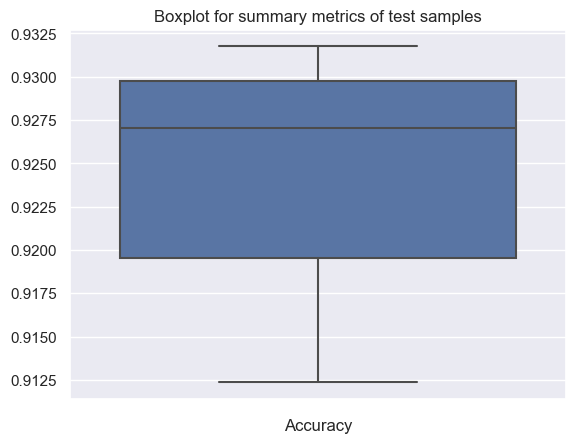

In [407]:
cv_errors = np.empty([nFolds,len(LR_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = LR_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_LR4 = meanAcc # Store cv-scores for later

ax = sns.boxplot(y=cv_errors.reshape(-1)).set_title('Boxplot for summary metrics of test samples')
plt.xlabel('Accuracy')
plt.show()

In [408]:
LR_fit.best_estimator_['LinReg'].summary(LR_fit.best_estimator_['Prep'].get_feature_names_out())

                            OLS Regression Results                            
Dep. Variable:            Utilizacion   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     2166.
Date:                Sat, 13 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:25:54   Log-Likelihood:                 23828.
No. Observations:               11692   AIC:                        -4.752e+04
Df Residuals:                   11624   BIC:                        -4.702e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
var                       coef            std err         t               P>|t|          
---------------------------------------------------------------------------
num__Irradiacion          0.075           0.

In [409]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [410]:
X_processed = LR_fit.best_estimator_['Prep'].transform(X_train)
coefnames = LR_fit.best_estimator_['Prep'].get_feature_names_out(INPUTS_LR)
#Identify correlated variables
vif = pd.DataFrame()
if isinstance(X_processed, scipy.sparse.csr.csr_matrix):
    X_processed = X_processed.toarray()
vif["VIF Factor"] = [variance_inflation_factor(X_processed, i) for i in range(X_processed.shape[1])]
vif["features"] = coefnames
vif.round(1)
#No vif>10, there is not multicolineality present in the model

C:\Users\Ainhoa\AppData\Local\Temp\ipykernel_19400\602679950.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if isinstance(X_processed, scipy.sparse.csr.csr_matrix):


,VIF Factor,features
0,10.8,num__Irradiacion
1,18.5,num__Irradiacion_lag1
2,13.1,num__Irradiacion_lag2
3,11.6,num__Irradiacion_lag8
4,9.6,num__Irradiacion_lag365
...,...,...
62,4.8,cat__FranjaHoraria_9
63,5.4,cat__FranjaHoraria_12
64,4.4,cat__FranjaHoraria_15
65,3.9,cat__FranjaHoraria_18


In [411]:
dfTR_eval

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365,Utilizacion
6323,2020,4,23,3,6,1.296732e+05,0.00,0.00,63635.453,61282.887,0.000000,0.000000,0.099917,0.035109,0.029436
17259,2020,3,30,0,21,0.000000e+00,0.00,992001.94,0.000,0.000,0.000000,0.062189,0.000000,0.000000,0.000000
9439,2016,11,2,2,12,1.507416e+06,875906.94,0.00,867919.100,253890.660,0.243882,0.032911,0.232068,0.087342,0.255274
17473,2020,10,30,4,21,0.000000e+00,0.00,778723.70,0.000,0.000,0.000000,0.051410,0.000000,0.000000,0.000000
5369,2017,9,12,1,6,7.804512e+03,0.00,0.00,20514.133,22217.970,0.004071,0.000000,0.049299,0.089030,0.053370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,2017,12,30,5,0,0.000000e+00,0.00,0.00,0.000,0.000,0.001809,0.001809,0.002714,0.002532,0.004523
2617,2016,3,1,1,3,0.000000e+00,0.00,0.00,0.000,0.000,0.004219,0.005063,0.001688,0.000000,0.000844
12969,2020,7,2,3,15,1.200177e+06,1800309.50,1234984.80,667452.250,1191216.200,0.106551,0.152570,0.069237,0.098870,0.053068
10712,2020,4,28,1,12,1.962550e+06,1805962.80,175615.92,1257850.200,2593440.000,0.294362,0.145937,0.210614,0.423729,0.383085


In [412]:
dfTR_eval['LR_pred'] = LR_fit.predict(X_train)
dfTS_eval['LR_pred'] = LR_fit.predict(X_test)

In [413]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['LR_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['LR_pred']))

#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['LR_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['LR_pred'])))

#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['LR_pred']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['LR_pred']))

Training MAE: 0.020260362598260157
Test MAE: 0.02093789653383084
Training RMSE: 0.031528180443418014
Test RMSE: 0.03238361635311125
Training R2: 0.9258539480616566
Test R2: 0.9193677910578724


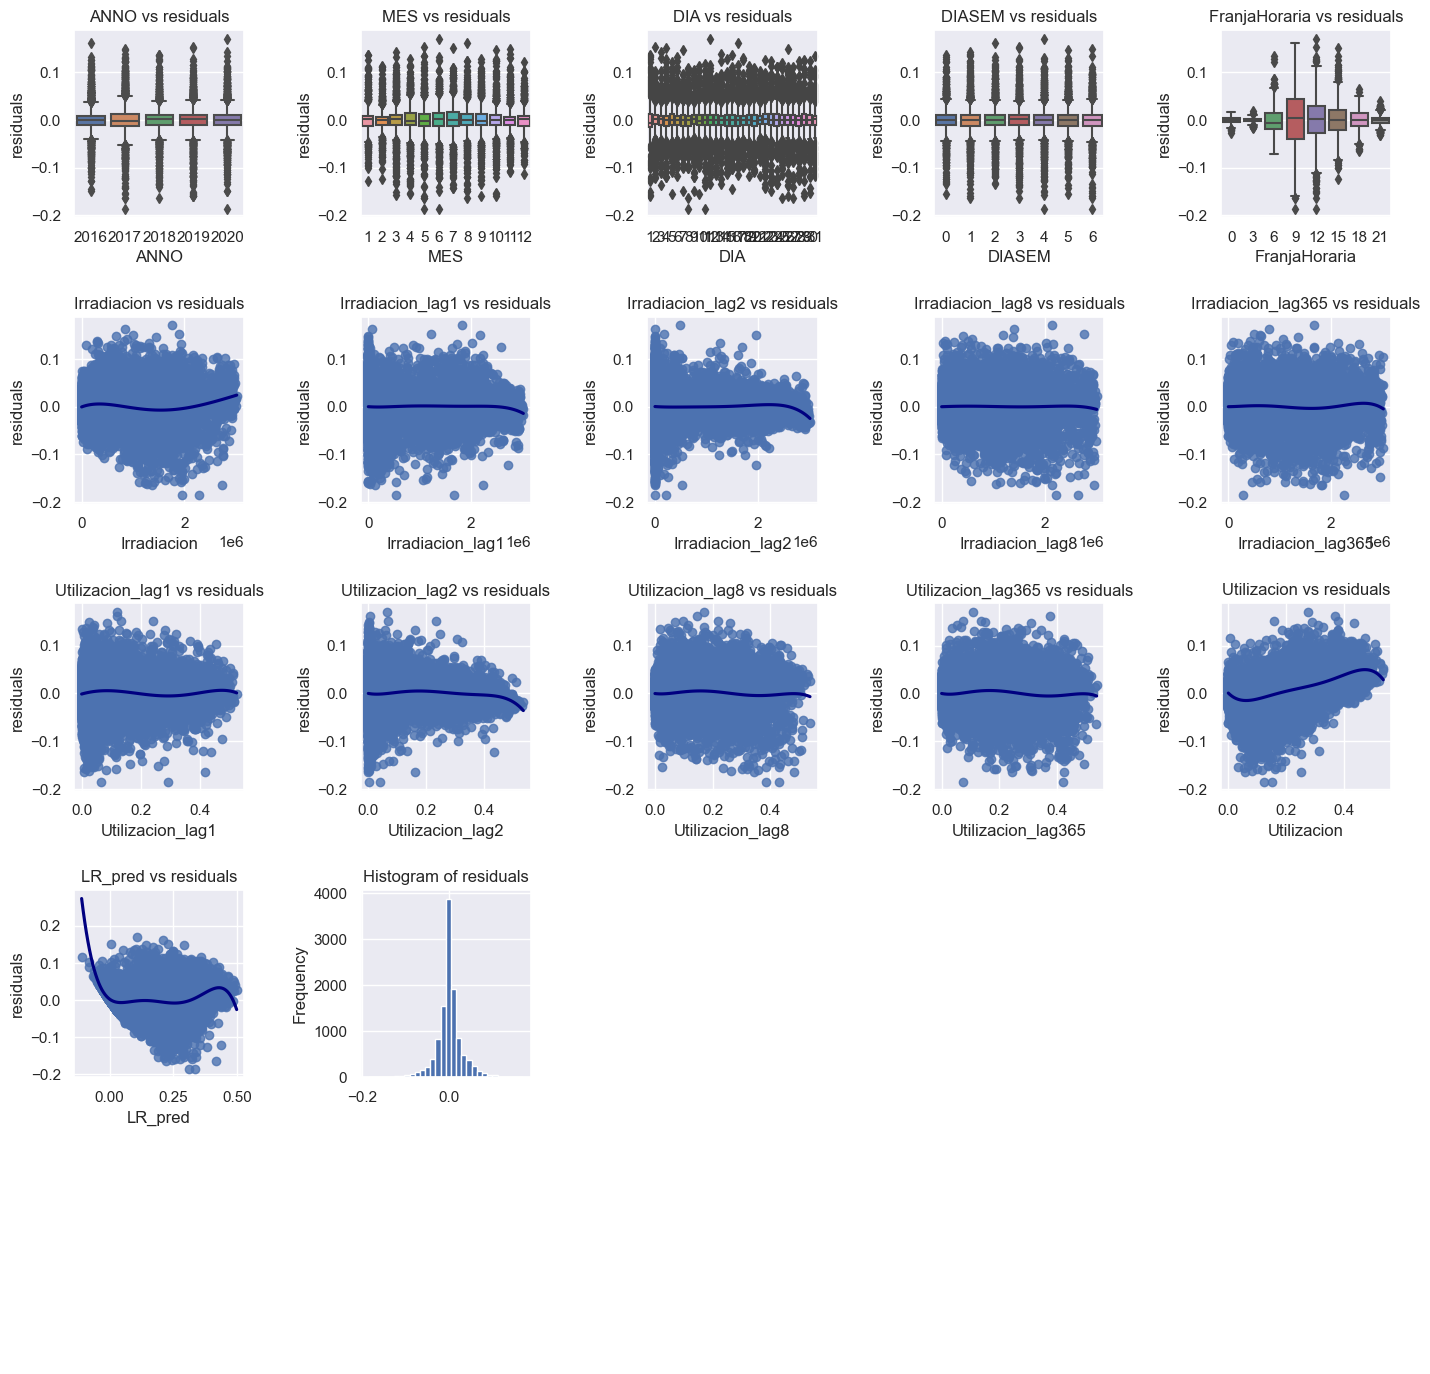

In [414]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'LR_pred', 'Utilizacion',figsize=[15,15])

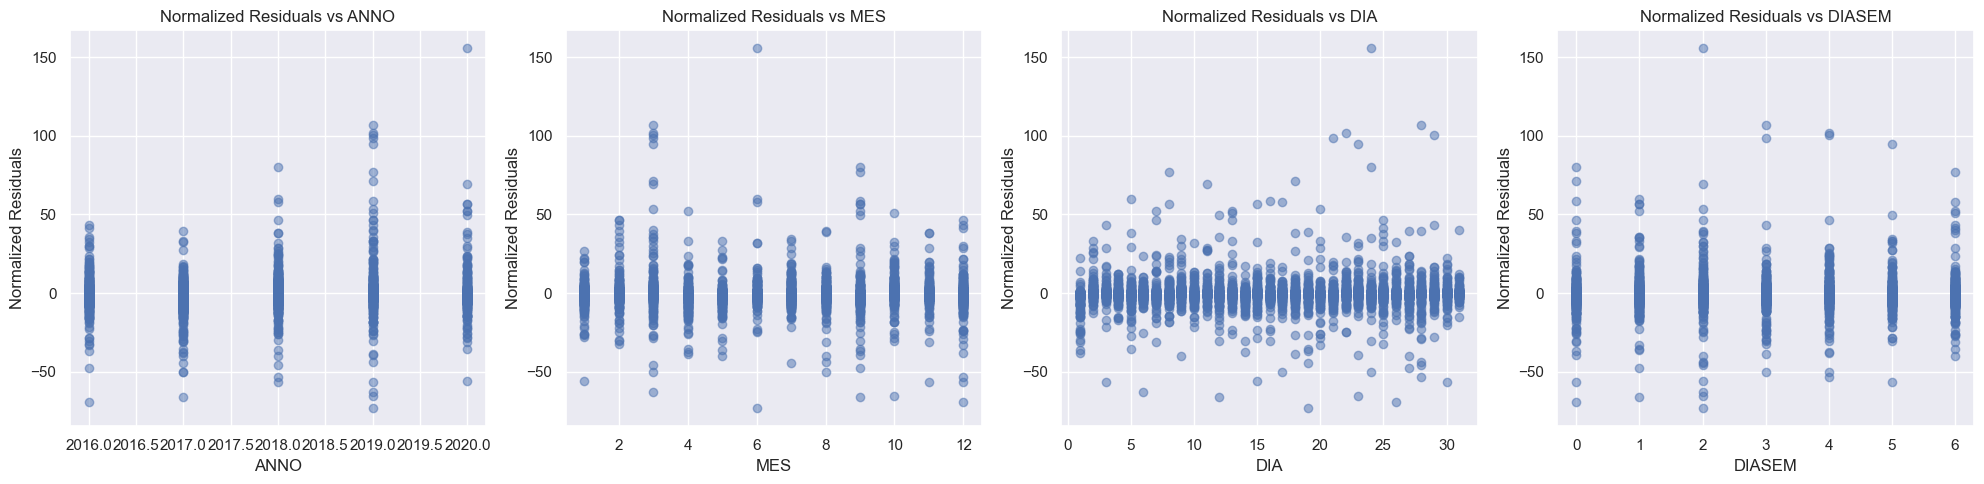

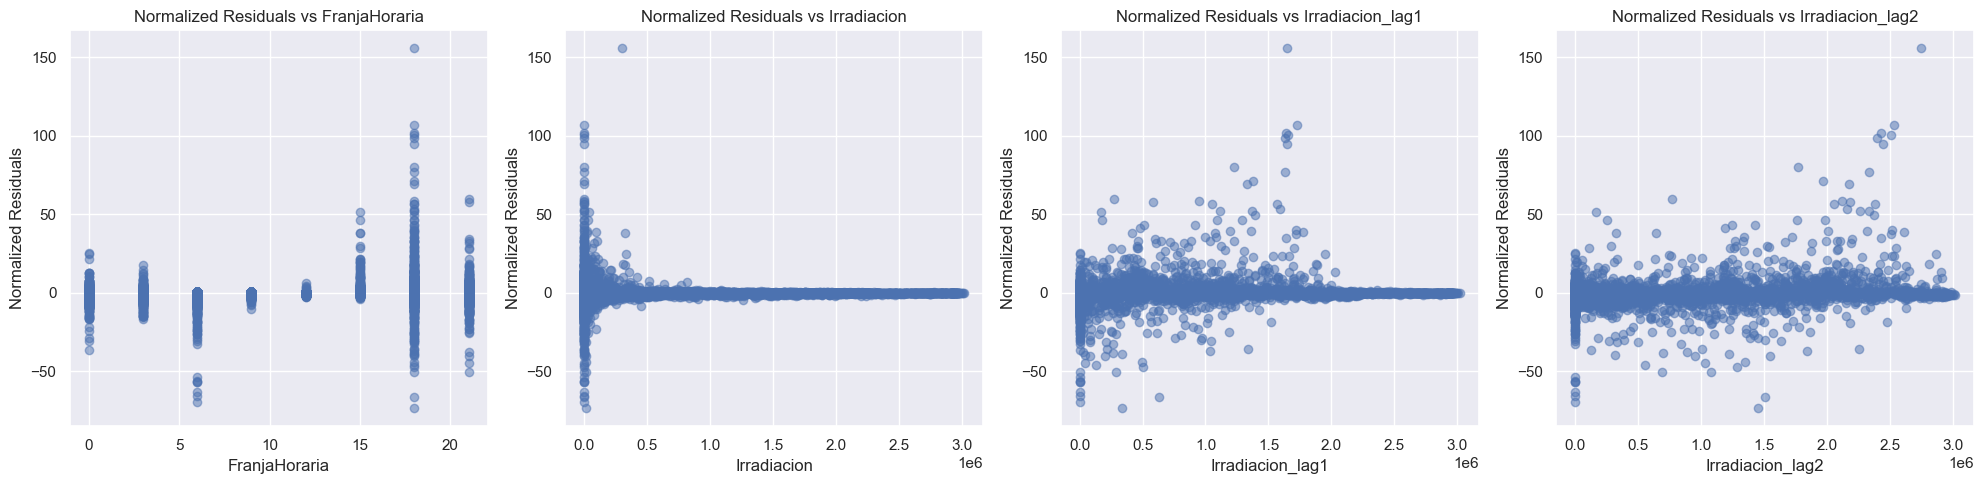

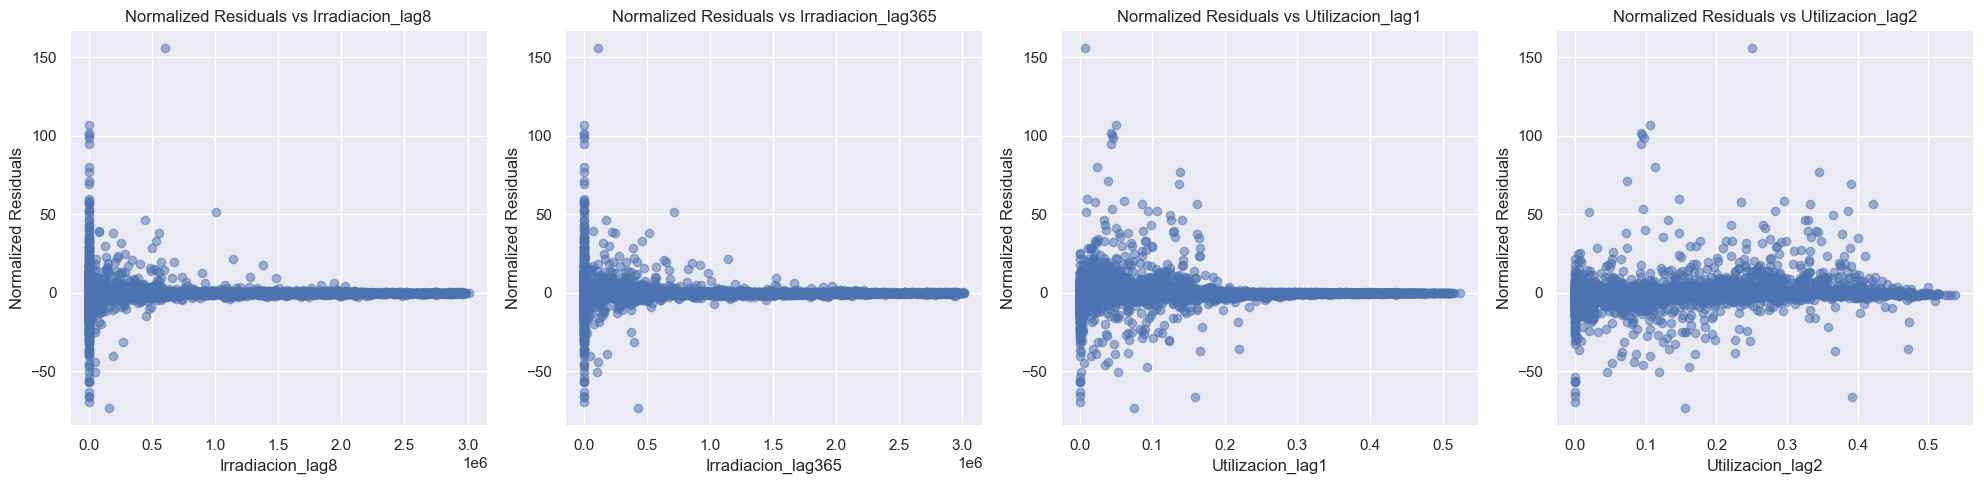

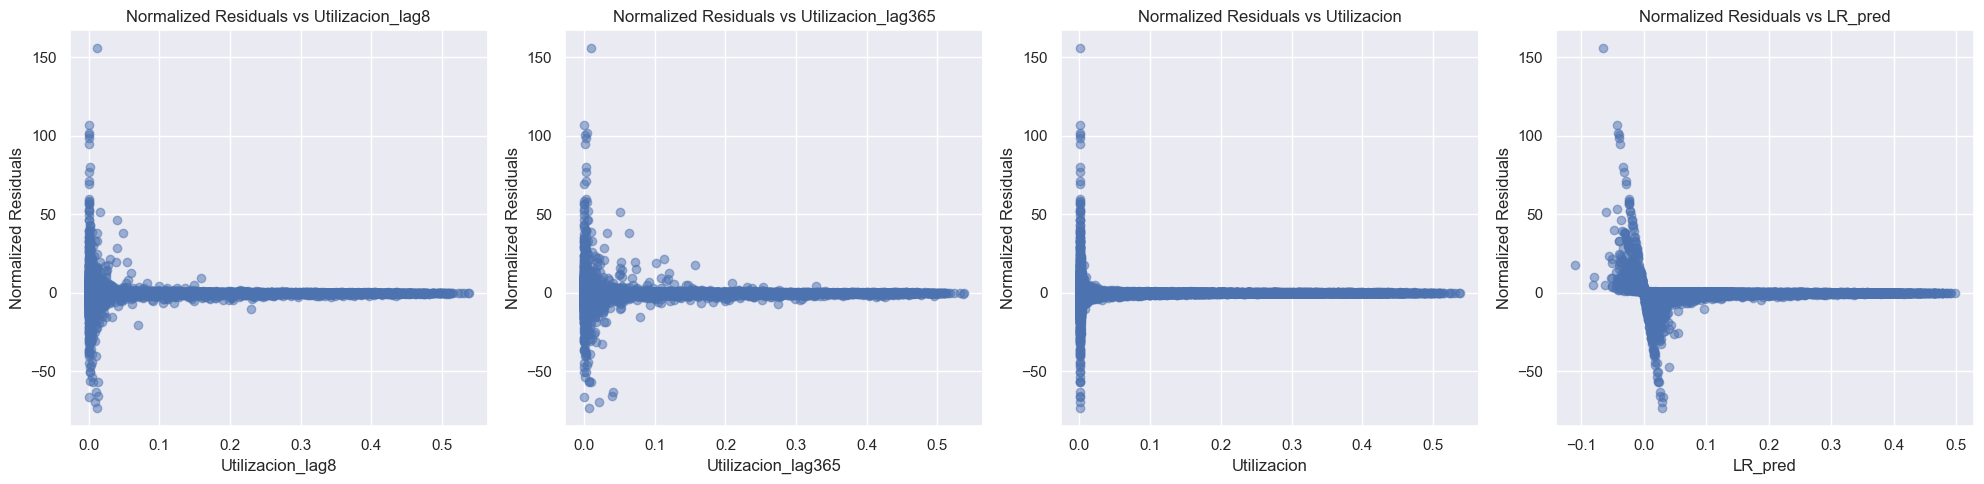

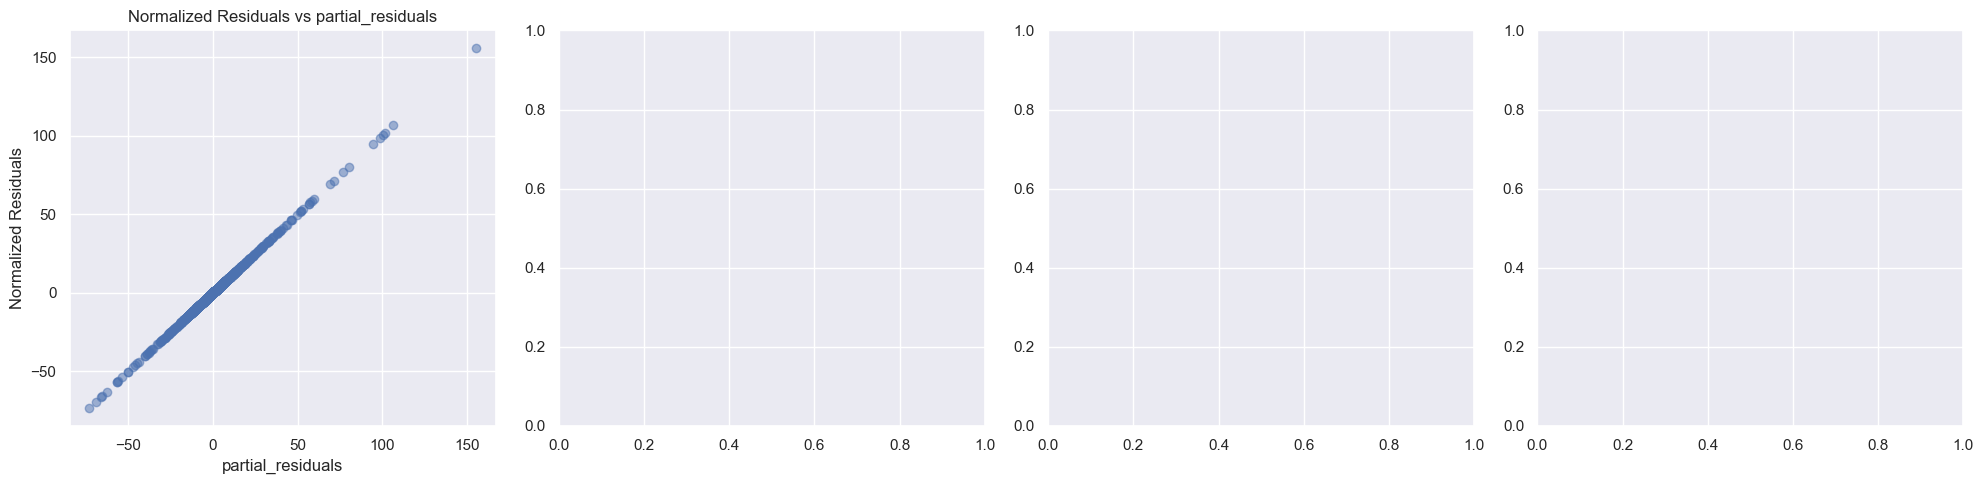

In [415]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Normalized Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Normalized Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()

### 4.2. MLP Regressor

In [416]:
## Create dataset to store model predictions
dfTR_eval2 = X_train.copy()
dfTR_eval2['Utilizacion'] = y_train
dfTS_eval2 = X_test.copy()
dfTS_eval2['Utilizacion'] = y_test

In [417]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_MLP_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.0001,0.001,0.01, 0.1, 1, 10, 100], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(5,),(13,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'FranjaHoraria'])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs',
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'MLP__hidden_layer_sizes': [(5,), (13,), (20,),
                                                     (25,)]},
             scoring='neg_mean_squared_error')

In [418]:
# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns

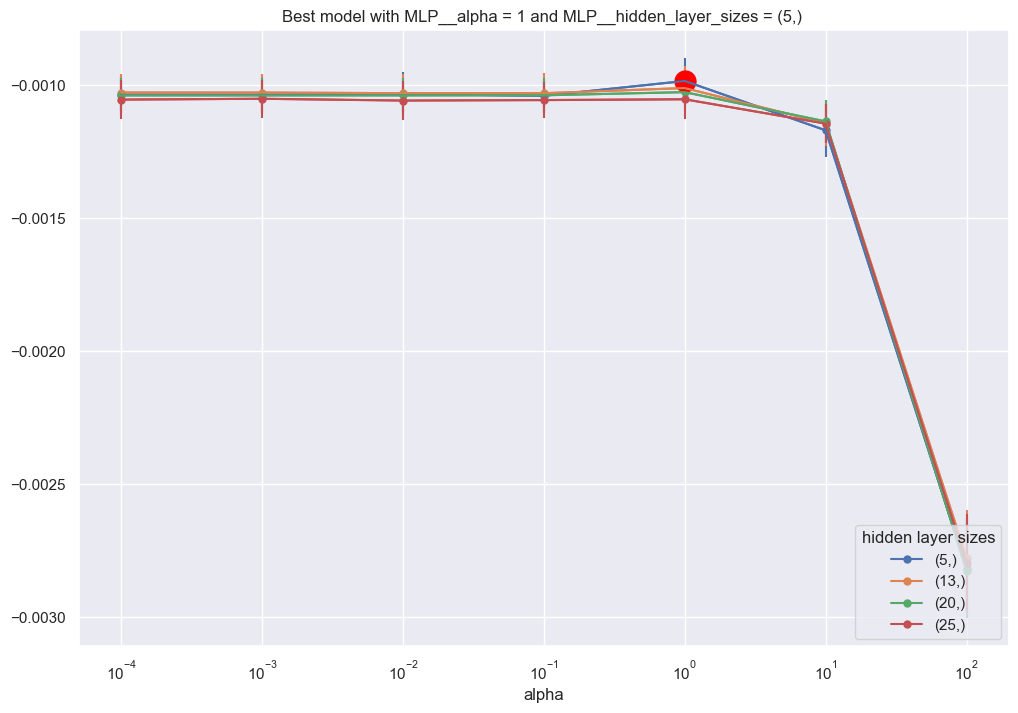

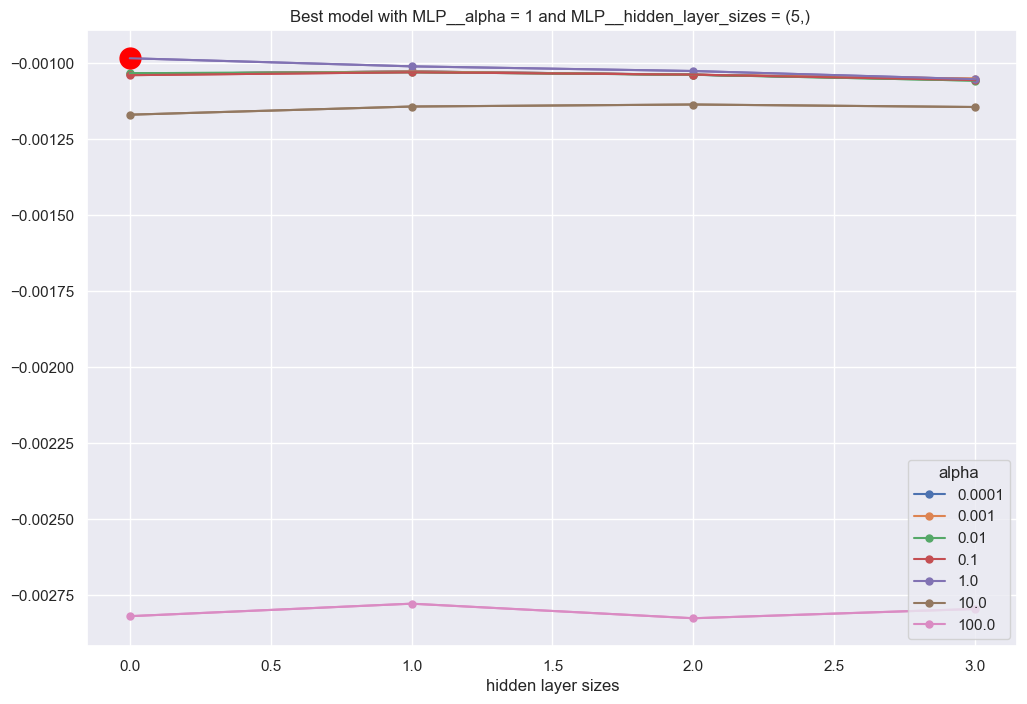

In [419]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [420]:
X

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
365,2016,1,1,4,0,0.000,0.000,0.000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
2557,2016,1,1,4,3,0.000,0.000,0.000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
4749,2016,1,1,4,6,0.000,0.000,0.000,0.00,0.00,0.000000,0.000000,0.018987,0.027848
6941,2016,1,1,4,9,343723.030,0.000,0.000,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443
9133,2016,1,1,4,12,734204.700,343723.030,0.000,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,2020,12,31,3,9,32165.098,0.000,0.000,147171.42,353766.80,0.002902,0.000000,0.046020,0.251244
10959,2020,12,31,3,12,75464.914,32165.098,0.000,228807.36,1009271.30,0.011194,0.002902,0.073383,0.276534
13151,2020,12,31,3,15,10270.279,75464.914,32165.098,236625.10,423595.50,0.024876,0.011194,0.024461,0.050580
15343,2020,12,31,3,18,0.000,10270.279,75464.914,0.00,0.00,0.001244,0.024876,0.000000,0.000415


In [421]:
print("Shape of X:", X.shape)
print("Number of feature names:", len(coefnames))

Shape of X: (14616, 14)
Number of feature names: 67


In [422]:
coefnames[:X.shape[1]]

array(['num__Irradiacion', 'num__Irradiacion_lag1',
       'num__Irradiacion_lag2', 'num__Irradiacion_lag8',
       'num__Irradiacion_lag365', 'num__Utilizacion_lag1',
       'num__Utilizacion_lag2', 'num__Utilizacion_lag8',
       'num__Utilizacion_lag365', 'cat__ANNO_2017', 'cat__ANNO_2018',
       'cat__ANNO_2019', 'cat__ANNO_2020', 'cat__MES_2'], dtype=object)

In [423]:
import scipy

In [424]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
if isinstance(X, scipy.sparse.csr.csr_matrix):
    X = X.toarray()
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames[:X.shape[1]])
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

C:\Users\Ainhoa\AppData\Local\Temp\ipykernel_19400\3617702159.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if isinstance(X, scipy.sparse.csr.csr_matrix):


Sensitivity analysis of [72, 5, 1] MLP network.

Sensitivity measures of each output:

$Y 

                             mean       std  mean_squared
num__Irradiacion         0.078612  0.010061      0.079253
num__Irradiacion_lag1   -0.045467  0.005454      0.045793
num__Irradiacion_lag2    0.012840  0.002237      0.013033
num__Irradiacion_lag8   -0.021160  0.004001      0.021535
num__Irradiacion_lag365 -0.008199  0.002280      0.008510
...                           ...       ...           ...
cat__FranjaHoraria_9     0.013881  0.000659      0.013897
cat__FranjaHoraria_12   -0.027025  0.002605      0.027150
cat__FranjaHoraria_15   -0.030551  0.005520      0.031046
cat__FranjaHoraria_18   -0.012602  0.001867      0.012740
cat__FranjaHoraria_21   -0.021816  0.003135      0.022040

[72 rows x 3 columns]


In [428]:
sensmlp.plot()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval2['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval2['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval2['Utilizacion'], dfTR_eval2['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval2['Utilizacion'], dfTS_eval2['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval2['Utilizacion'], dfTR_eval2['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval2['Utilizacion'], dfTS_eval2['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval2['Utilizacion'], dfTR_eval2['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval2['Utilizacion'], dfTS_eval2['MLP_pred']))

Training MAE: 0.018737944245816058
Test MAE: 0.019482465439399844
Training RMSE: 0.030306871272858193
Test RMSE: 0.031326944053061856
Training R2: 0.931487088292795
Test R2: 0.9245439739620587


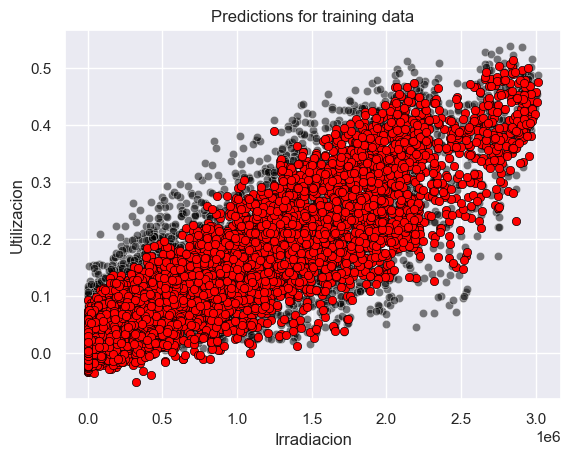

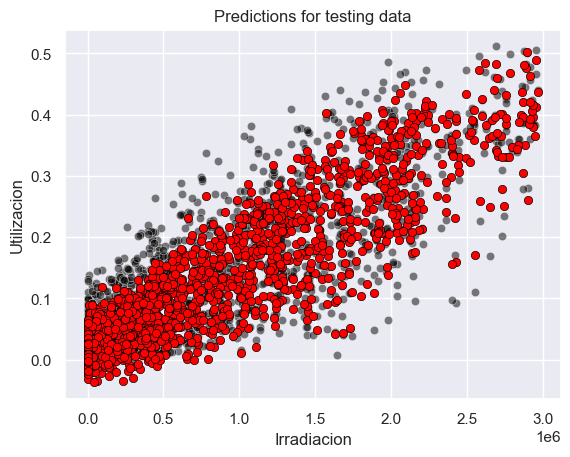

In [ ]:
### Plot predictions of the model
sns.scatterplot(x='Irradiacion', y='Utilizacion', data=dfTR_eval2, color='black', alpha=0.5)
sns.scatterplot(x='Irradiacion', y='MLP_pred', data=dfTR_eval2, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='Irradiacion', y='Utilizacion', data=dfTS_eval2, color='black', alpha=0.5)
sns.scatterplot(x='Irradiacion', y='MLP_pred', data=dfTS_eval2, color='red', edgecolor='black').set_title('Predictions for testing data')
plt.show()

In [ ]:
dfTR_eval2.dtypes


ANNO                  category
MES                   category
DIA                   category
DIASEM                category
FranjaHoraria         category
Irradiacion            float64
Irradiacion_lag1       float64
Irradiacion_lag2       float64
Irradiacion_lag8       float64
Irradiacion_lag365     float64
Utilizacion_lag1       float64
Utilizacion_lag2       float64
Utilizacion_lag8       float64
Utilizacion_lag365     float64
Utilizacion            float64
MLP_pred               float64
dtype: object

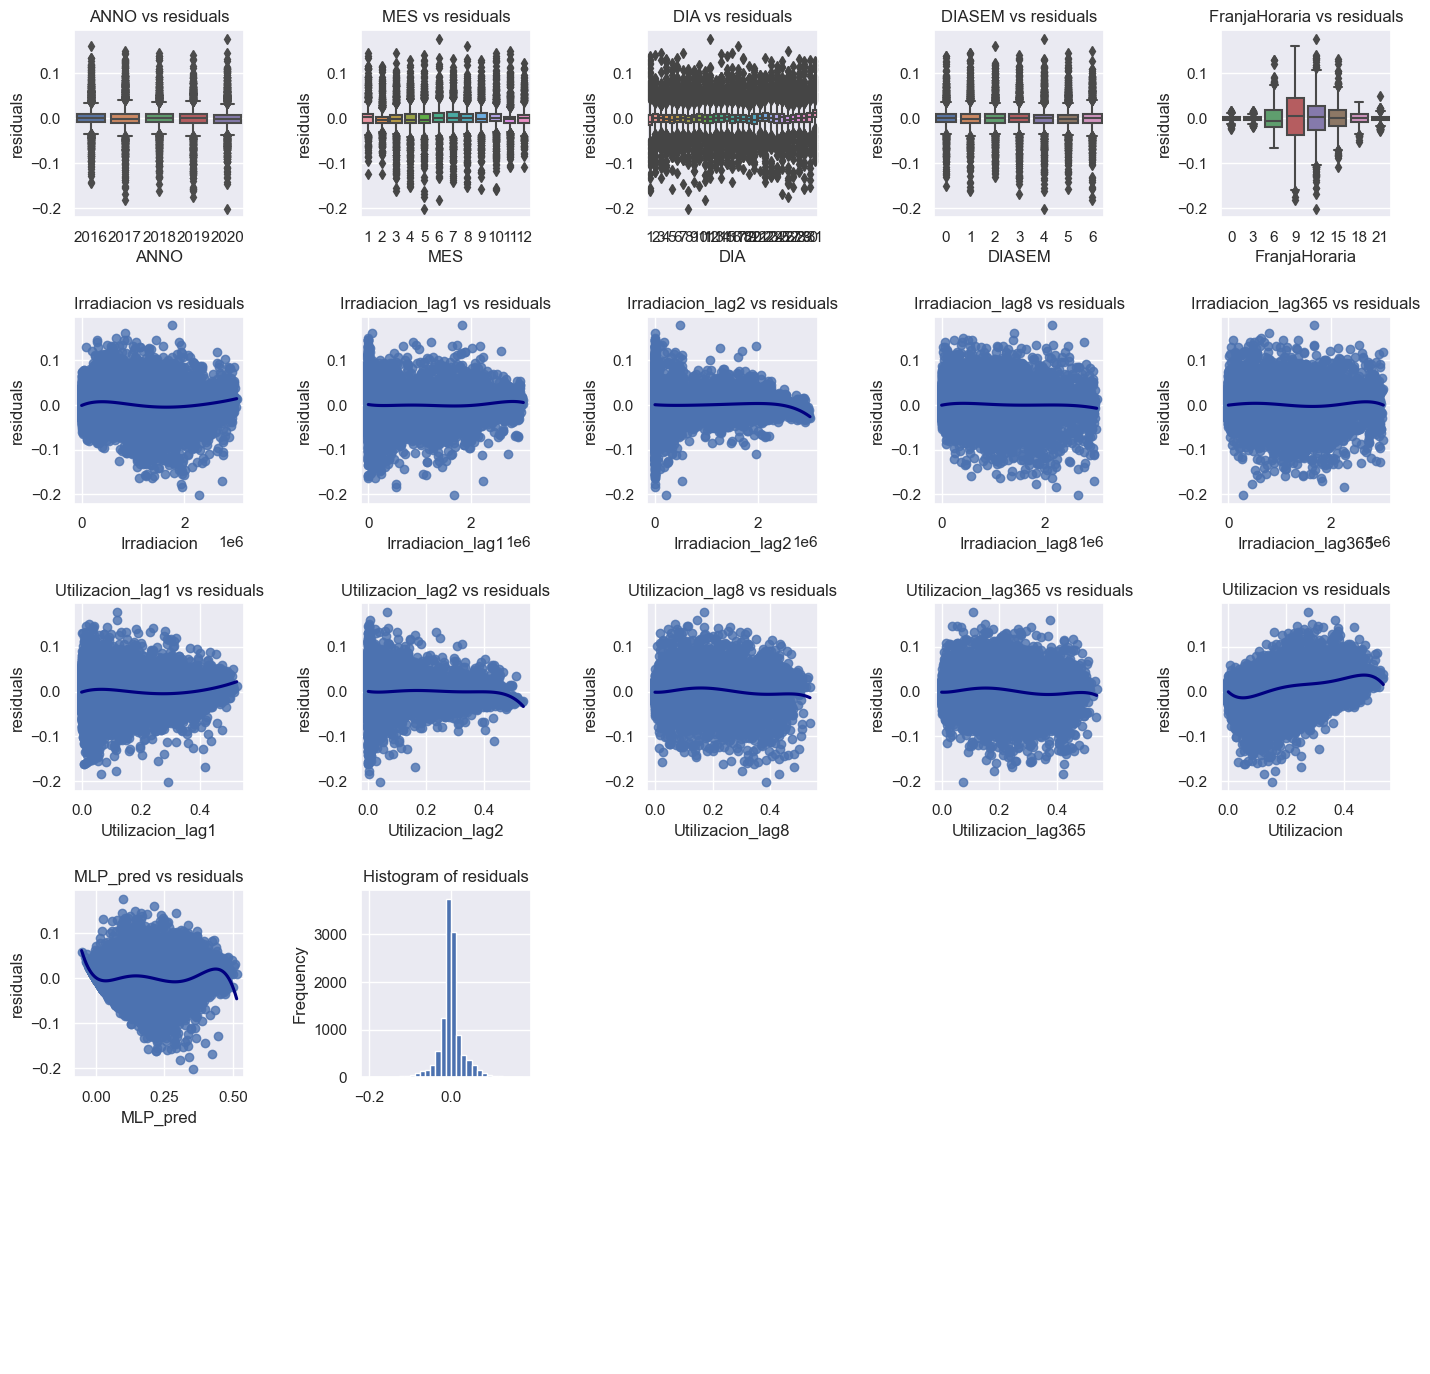

In [ ]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval2, 'MLP_pred', 'Utilizacion', figsize=[15,15])

In [ ]:
dfTR_eval2 = dfTR_eval2[dfTR_eval2['Utilizacion'] != 0]

In [ ]:
dfTR_eval2['partial_residuals'] = dfTR_eval2['residuals'] / dfTR_eval2['Utilizacion']

In [ ]:
dfTR_eval2

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365,Utilizacion,MLP_pred,residuals,partial_residuals
6323,2020,4,23,3,6,1.296732e+05,0.000,0.00,63635.453,61282.887,0.000000,0.000000,0.099917,0.035109,0.029436,0.064712,-0.035276,-1.198382
9439,2016,11,2,2,12,1.507416e+06,875906.940,0.00,867919.100,253890.660,0.243882,0.032911,0.232068,0.087342,0.255274,0.297818,-0.042544,-0.166660
5369,2017,9,12,1,6,7.804512e+03,0.000,0.00,20514.133,22217.970,0.004071,0.000000,0.049299,0.089030,0.053370,0.055168,-0.001799,-0.033699
7467,2017,6,10,5,9,2.215842e+06,590960.250,0.00,1665111.500,1244250.600,0.164135,0.007173,0.298312,0.164979,0.429536,0.393839,0.035697,0.083105
3838,2019,7,5,4,3,0.000000e+00,0.000,0.00,0.000,0.000,0.000000,0.000000,0.002421,0.003641,0.002825,0.002913,-0.000088,-0.031085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8280,2019,9,1,6,9,2.012360e+05,9664.076,0.00,647522.000,1806735.800,0.052058,0.011703,0.073850,0.353560,0.087167,0.100212,-0.013045,-0.149650
1094,2017,12,30,5,0,0.000000e+00,0.000,0.00,0.000,0.000,0.001809,0.001809,0.002714,0.002532,0.004523,-0.000061,0.004584,1.013493
2617,2016,3,1,1,3,0.000000e+00,0.000,0.00,0.000,0.000,0.004219,0.005063,0.001688,0.000000,0.000844,0.017974,-0.017130,-20.299309
12969,2020,7,2,3,15,1.200177e+06,1800309.500,1234984.80,667452.250,1191216.200,0.106551,0.152570,0.069237,0.098870,0.053068,0.052559,0.000509,0.009583


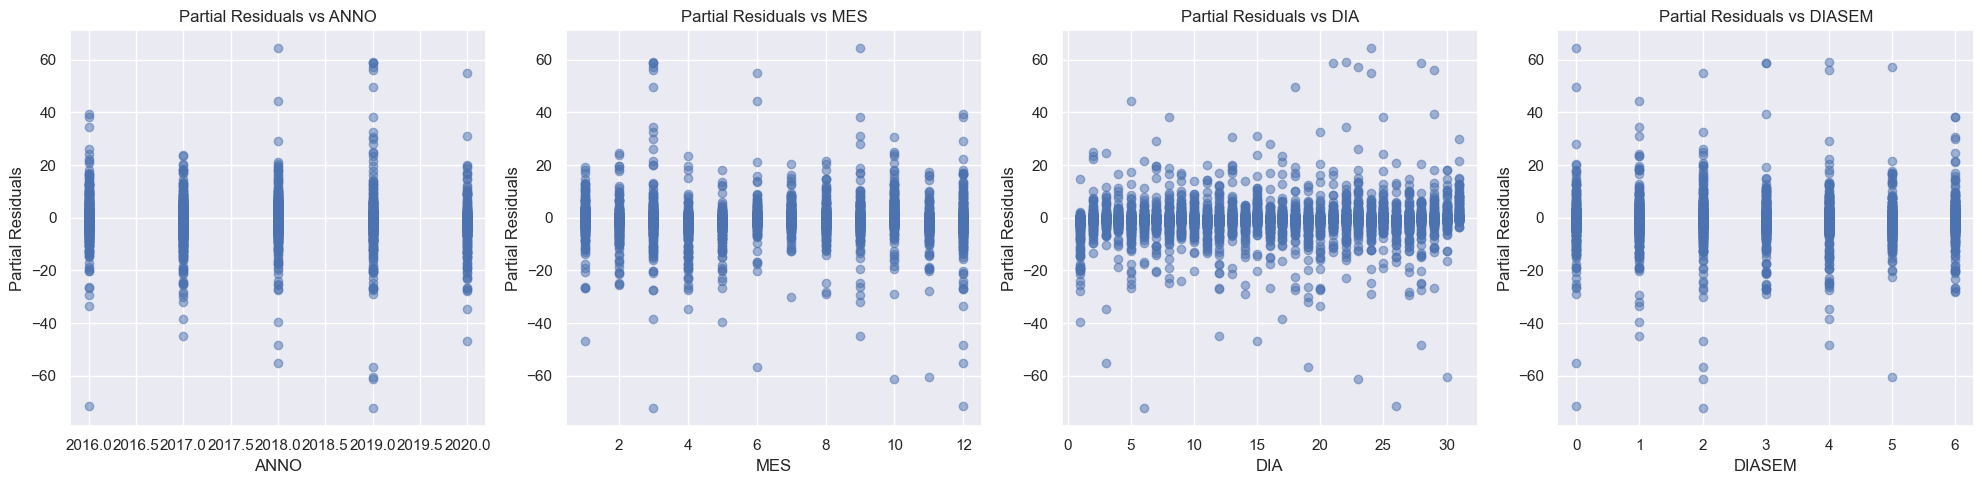

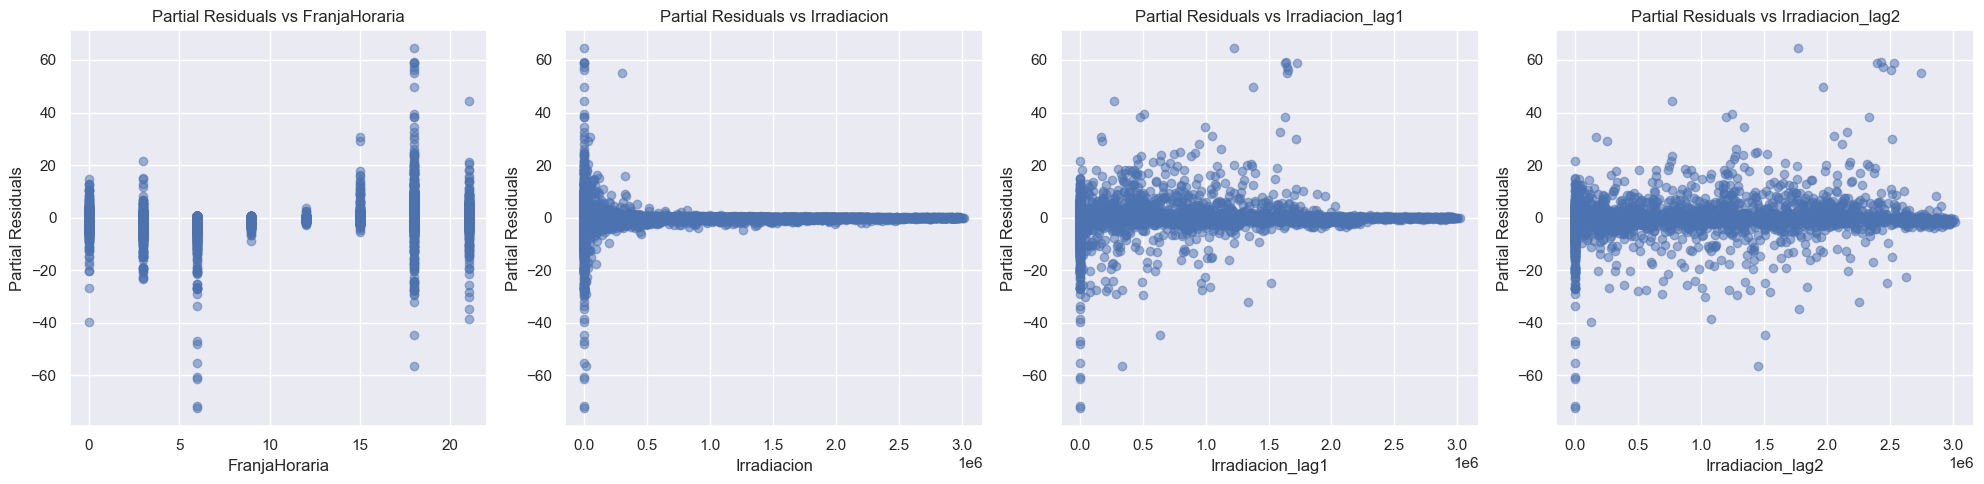

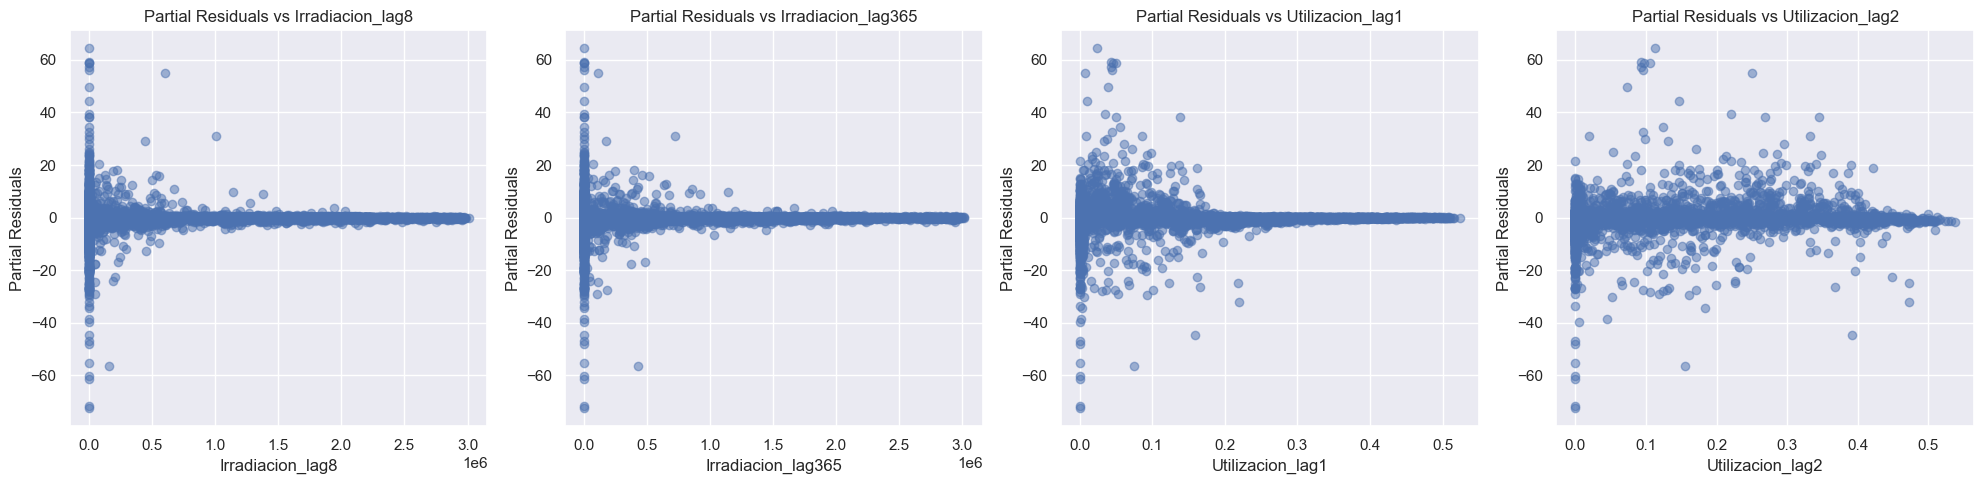

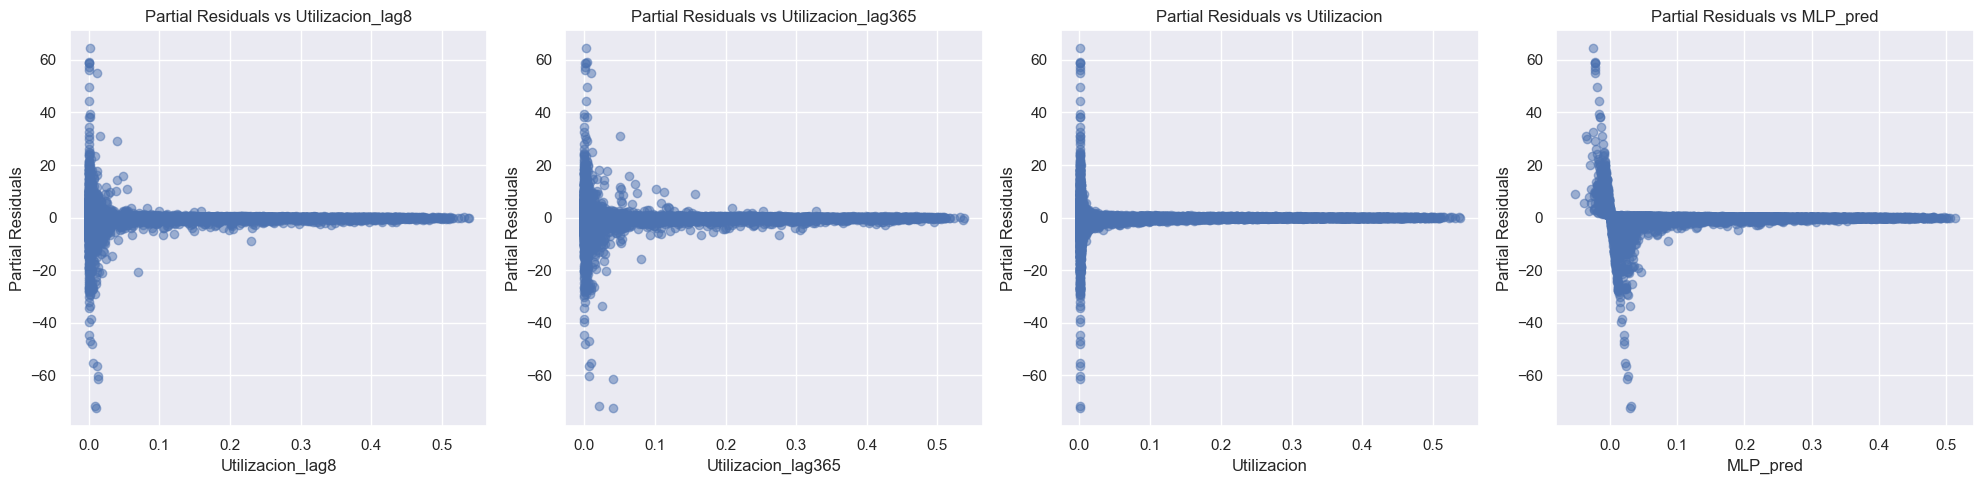

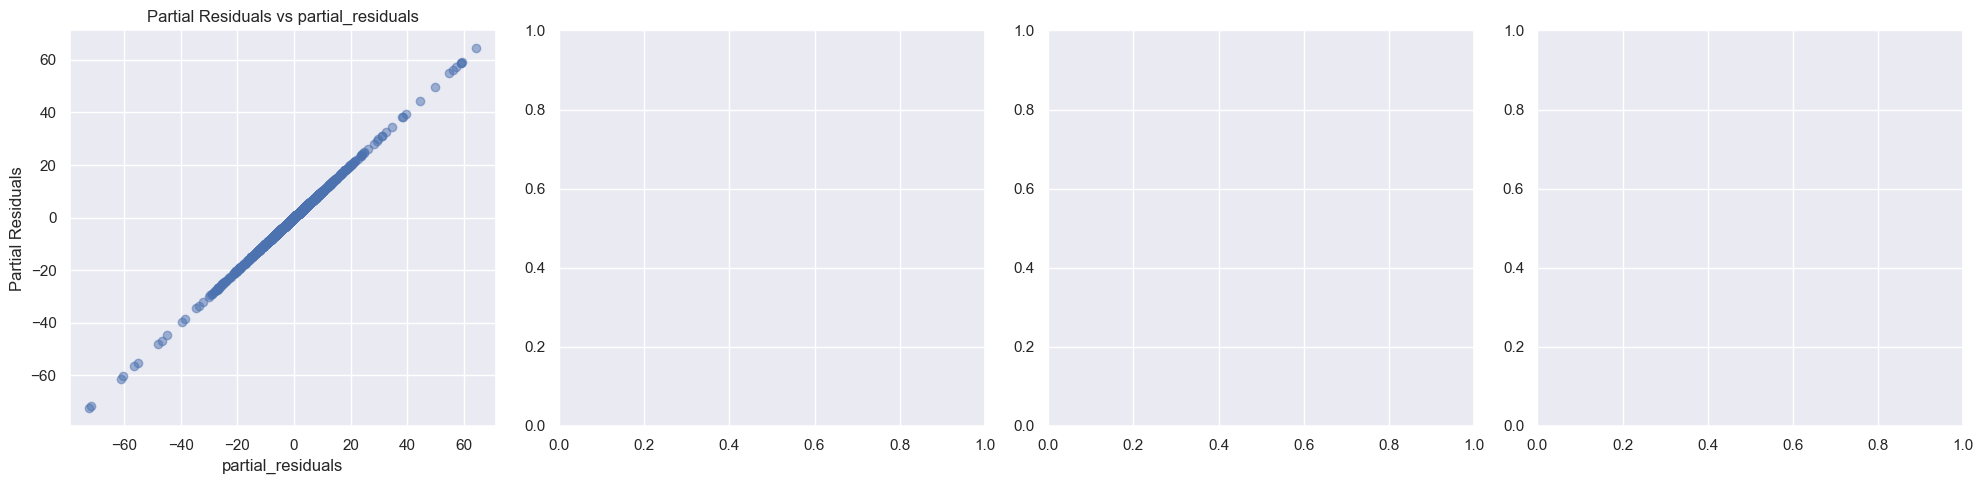

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes

# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval2.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval2[variable], dfTR_eval2['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Partial Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Partial Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()


Los gráficos que has compartido muestran los residuos parciales de un modelo para diferentes variables independientes. Los residuos parciales representan la relación entre la respuesta y las variables independientes, ajustando por los efectos de todas las otras variables en el modelo. Este tipo de gráfico puede ayudarte a entender cómo cada variable independiente está relacionada con la respuesta, después de tomar en cuenta el efecto de las otras variables. Veamos cómo interpretar estos gráficos:

### 1. Distribución de los Residuos
El patrón de los puntos alrededor del eje horizontal (cero en el eje y) nos da una indicación de cómo los valores predichos por el modelo se comparan con los valores reales. Idealmente, queremos que los residuos estén distribuidos aleatoriamente alrededor del eje horizontal, sin patrones discernibles.

### 2. Residuos vs Variables Independientes
- Si ves un patrón claro en la dispersión de residuos para una variable independiente (como una forma de U, una tendencia lineal, etc.), esto podría indicar que el modelo actual no captura completamente la relación entre la variable independiente y la variable dependiente.
- Si los residuos parecen ser aleatorios sin un patrón claro, esto puede indicar que la relación entre la variable independiente y la variable dependiente se ha capturado bien.

### 3. Homocedasticidad
- Idealmente, la varianza de los residuos debería ser constante a través de los rangos de las variables independientes, lo cual se conoce como homoscedasticidad.
- Si observas que la dispersión de los residuos cambia (por ejemplo, se expande o contrae) en diferentes rangos de la variable independiente, esto podría indicar heteroscedasticidad, lo cual es un signo de que el modelo podría no estar adecuadamente especificado.

### 4. Outliers
- Los puntos que están significativamente alejados de los demás pueden ser outliers. Estos pueden ser debidos a errores en los datos o a casos que son intrínsecamente diferentes a la mayoría de los otros casos.

### Interpretación Específica de Tus Gráficos:
- En los gráficos de "Utilizacion" y "MLP_pred", parece haber un acúmulo de residuos alrededor de valores bajos de las variables independientes, lo cual puede sugerir que el modelo no funciona bien en esa región particular.
- En el gráfico "Partial Residuals vs partial_residuals", observamos una línea perfecta, lo cual es de esperarse ya que está graficando los residuos parciales contra sí mismos.
- En los gráficos de "Irradiacion", parecería que hay un patrón en los residuos para valores bajos de irradiación, lo que podría indicar un problema en cómo el modelo está manejando esa variable en particular.
- Los gráficos de "ANNO", "MES", "DIA" y "FranjaHoraria" parecen mostrar que no hay un patrón claro o tendencia en los residuos a lo largo de estas variables temporales, aunque hay una variabilidad notable que podría requerir una investigación más detallada.

Es importante tener en cuenta que esta es solo una interpretación preliminar y que otros factores podrían estar en juego. Por ejemplo, el rango de las variables y la escala de los residuos pueden influir en la apariencia de los gráficos. Además, la interpretación debe ser considerada junto con otras métricas de diagnóstico y un entendimiento del contexto y los datos subyacentes.